In [50]:
import polars as pl

df_orig = pl.read_csv("Healthcare.csv")
df_orig

shape: (25_000, 6)
┌────────────┬─────┬────────┬─────────────────────────────────┬───────────────┬──────────────────┐
│ Patient_ID ┆ Age ┆ Gender ┆ Symptoms                        ┆ Symptom_Count ┆ Disease          │
│ ---        ┆ --- ┆ ---    ┆ ---                             ┆ ---           ┆ ---              │
│ i64        ┆ i64 ┆ str    ┆ str                             ┆ i64           ┆ str              │
╞════════════╪═════╪════════╪═════════════════════════════════╪═══════════════╪══════════════════╡
│ 1          ┆ 29  ┆ Male   ┆ fever, back pain, shortness of… ┆ 3             ┆ Allergy          │
│ 2          ┆ 76  ┆ Female ┆ insomnia, back pain, weight lo… ┆ 3             ┆ Thyroid Disorder │
│ 3          ┆ 78  ┆ Male   ┆ sore throat, vomiting, diarrhe… ┆ 3             ┆ Influenza        │
│ 4          ┆ 58  ┆ Other  ┆ blurred vision, depression, we… ┆ 4             ┆ Stroke           │
│ 5          ┆ 55  ┆ Female ┆ swelling, appetite loss, nause… ┆ 3             ┆ Heart Disease    │
│ …          ┆ …   ┆ …      ┆ …                               ┆ …             ┆ …                │
│ 24996      ┆ 42  ┆ Male   ┆ runny nose, muscle pain, anxie… ┆ 6             ┆ Ulcer            │
│ 24997      ┆ 36  ┆ Male   ┆ fever, blurred vision, insomni… ┆ 6             ┆ Common Cold      │
│ 24998      ┆ 70  ┆ Other  ┆ anxiety, nausea, tremors        ┆ 3             ┆ Anxiety          │
│ 24999      ┆ 9   ┆ Other  ┆ muscle pain, rash, diarrhea, j… ┆ 4             ┆ Obesity          │
│ 25000      ┆ 27  ┆ Female ┆ sweating, abdominal pain, feve… ┆ 7             ┆ Parkinson's      │
└────────────┴─────┴────────┴─────────────────────────────────┴───────────────┴──────────────────┘

In [51]:
df_orig=df_orig.drop(["Patient_ID"])

In [52]:
for c in df_orig.columns:
    print(df_orig[c].value_counts())

shape: (90, 2)
┌─────┬───────┐
│ Age ┆ count │
│ --- ┆ ---   │
│ i64 ┆ u32   │
╞═════╪═══════╡
│ 49  ┆ 288   │
│ 18  ┆ 285   │
│ 2   ┆ 298   │
│ 67  ┆ 294   │
│ 15  ┆ 282   │
│ …   ┆ …     │
│ 87  ┆ 236   │
│ 89  ┆ 305   │
│ 1   ┆ 302   │
│ 13  ┆ 236   │
│ 66  ┆ 288   │
└─────┴───────┘
shape: (3, 2)
┌────────┬───────┐
│ Gender ┆ count │
│ ---    ┆ ---   │
│ str    ┆ u32   │
╞════════╪═══════╡
│ Other  ┆ 8393  │
│ Male   ┆ 8271  │
│ Female ┆ 8336  │
└────────┴───────┘
shape: (24_359, 2)
┌─────────────────────────────────┬───────┐
│ Symptoms                        ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ cough, diarrhea, joint pain, s… ┆ 1     │
│ dizziness, vomiting, chest pai… ┆ 1     │
│ headache, sore throat, fatigue… ┆ 1     │
│ shortness of breath, abdominal… ┆ 1     │
│ weight loss, sore throat, ches… ┆ 1     │
│ …                               ┆ …     │
│ back pain, appetite los

In [53]:
disease_col = df_orig["Disease"]

In [54]:


df = df_orig.with_columns(
    pl.col('Symptoms').str.split(", ")
)

# Step 2: Get all unique symptoms
all_symptoms = (
    df.explode("Symptoms")
    .select(pl.col("Symptoms").unique())
    .to_series()
    .to_list()
)

# Clean up whitespace just in case (optional but safe)
all_symptoms = [s.strip() for s in all_symptoms]

# Step 3: For each symptom, create a binary column
symptom_exprs = [
    pl.when(pl.col("Symptoms").list.contains(symptom))
      .then(1)
      .otherwise(0)
      .alias(f"Symptom_{symptom.replace(' ', '_')}")
    for symptom in all_symptoms
]

# Step 4: Add all one-hot columns
result = df.select(symptom_exprs)
df=df.drop(['Symptoms'])


print(result)

shape: (25_000, 28)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Symptom_b ┆ Symptom_a ┆ Symptom_j ┆ Symptom_c ┆ … ┆ Symptom_f ┆ Symptom_s ┆ Symptom_s ┆ Symptom_ │
│ ack_pain  ┆ ppetite_l ┆ oint_pain ┆ ough      ┆   ┆ ever      ┆ neezing   ┆ hortness_ ┆ rash     │
│ ---       ┆ oss       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ of_breath ┆ ---      │
│ i32       ┆ ---       ┆ i32       ┆ i32       ┆   ┆ i32       ┆ i32       ┆ ---       ┆ i32      │
│           ┆ i32       ┆           ┆           ┆   ┆           ┆           ┆ i32       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1         ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 1         ┆ 0         ┆ 1         ┆ 0        │
│ 1         ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0        │
│ 0         ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0    

In [55]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
pca = PCA(n_components=4)
result_norm = RobustScaler().fit_transform(result)
pca_symptoms = pca.fit_transform(result_norm)
symptoms_df = pl.DataFrame(pca_symptoms,
    ["Symptoms_D1","Symptoms_D2","Symptoms_D3","Symptoms_D4"]
)
pca.explained_variance_ratio_

array([0.03862536, 0.03839314, 0.03809068, 0.03800073])

In [56]:
# df = df.drop(["Symptom"])
df = pl.concat([df,symptoms_df],how="horizontal")
df

shape: (25_000, 8)
┌─────┬────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ Age ┆ Gender ┆ Symptom_Cou ┆ Disease     ┆ Symptoms_D1 ┆ Symptoms_D2 ┆ Symptoms_D3 ┆ Symptoms_D4 │
│ --- ┆ ---    ┆ nt          ┆ ---         ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
│ i64 ┆ str    ┆ ---         ┆ str         ┆ f64         ┆ f64         ┆ f64         ┆ f64         │
│     ┆        ┆ i64         ┆             ┆             ┆             ┆             ┆             │
╞═════╪════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 29  ┆ Male   ┆ 3           ┆ Allergy     ┆ -0.012421   ┆ -0.35888    ┆ -0.415904   ┆ -0.251617   │
│ 76  ┆ Female ┆ 3           ┆ Thyroid     ┆ 0.18064     ┆ 0.580212    ┆ -0.025196   ┆ 0.045834    │
│     ┆        ┆             ┆ Disorder    ┆             ┆             ┆             ┆             │
│ 78  ┆ Male   ┆ 3           ┆ Influenza   ┆ 0.269444    ┆ -0.215358   ┆ -0.07469    ┆ -0.15591    │
│ 58  ┆ Other  ┆ 4           ┆ Stroke      ┆ 0.090755    ┆ 0.364419    ┆ 0.311787    ┆ -0.222661   │
│ 55  ┆ Female ┆ 3           ┆ Heart       ┆ -0.1926     ┆ 0.147828    ┆ -0.102796   ┆ -0.059335   │
│     ┆        ┆             ┆ Disease     ┆             ┆             ┆             ┆             │
│ …   ┆ …      ┆ …           ┆ …           ┆ …           ┆ …           ┆ …           ┆ …           │
│ 42  ┆ Male   ┆ 6           ┆ Ulcer       ┆ -0.20057    ┆ -0.045716   ┆ 0.117032    ┆ -0.375302   │
│ 36  ┆ Male   ┆ 6           ┆ Common Cold ┆ 0.166002    ┆ -0.278468   ┆ -0.111911   ┆ 0.378084    │
│ 70  ┆ Other  ┆ 3           ┆ Anxiety     ┆ -0.428272   ┆ 0.378745    ┆ -0.268704   ┆ -0.040094   │
│ 9   ┆ Other  ┆ 4           ┆ Obesity     ┆ -0.069648   ┆ -0.331564   ┆ 0.251092    ┆ 0.234196    │
│ 27  ┆ Female ┆ 7           ┆ Parkinson's ┆ -0.453046   ┆ 0.192396    ┆ -0.200454   ┆ 0.099064    │
└─────┴────────┴─────────────┴─────────────┴─────────────┴─────────────┴─────────────┴─────────────┘

In [57]:
df = df.with_columns(pl.col("Gender").cast(pl.Categorical).to_physical())

In [58]:
# These are diseases that i work with
allowed_diseases = ['Allergy','Stroke','Influenza','Heart Disease']
allowed_diseases_id = [0,1,2,3]

diseases_mapping = {a:b for a,b in zip(allowed_diseases,allowed_diseases_id)}
diseases_mapping_inv = {a:b for a,b in zip(allowed_diseases_id,allowed_diseases)}


In [59]:
print("Before filtering",len(df))
df = df.filter(df['Disease'].is_in(allowed_diseases))
df = df.with_columns(
    pl.col("Disease").map_elements(lambda x: diseases_mapping[x], return_dtype=pl.Int64).alias("Disease_id")
)
print("After filtering",len(df))
df

Before filtering 25000
After filtering 3276


shape: (3_276, 9)
┌─────┬────────┬─────────────┬─────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ Age ┆ Gender ┆ Symptom_Cou ┆ Disease     ┆ … ┆ Symptoms_D ┆ Symptoms_D ┆ Symptoms_D ┆ Disease_id │
│ --- ┆ ---    ┆ nt          ┆ ---         ┆   ┆ 2          ┆ 3          ┆ 4          ┆ ---        │
│ i64 ┆ u32    ┆ ---         ┆ str         ┆   ┆ ---        ┆ ---        ┆ ---        ┆ i64        │
│     ┆        ┆ i64         ┆             ┆   ┆ f64        ┆ f64        ┆ f64        ┆            │
╞═════╪════════╪═════════════╪═════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 29  ┆ 0      ┆ 3           ┆ Allergy     ┆ … ┆ -0.35888   ┆ -0.415904  ┆ -0.251617  ┆ 0          │
│ 78  ┆ 0      ┆ 3           ┆ Influenza   ┆ … ┆ -0.215358  ┆ -0.07469   ┆ -0.15591   ┆ 2          │
│ 58  ┆ 2      ┆ 4           ┆ Stroke      ┆ … ┆ 0.364419   ┆ 0.311787   ┆ -0.222661  ┆ 1          │
│ 55  ┆ 1      ┆ 3           ┆ Heart       ┆ … ┆ 0.147828   ┆ -0.102796  ┆ -0.059335  ┆ 3          │
│     ┆        ┆             ┆ Disease     ┆   ┆            ┆            ┆            ┆            │
│ 49  ┆ 0      ┆ 4           ┆ Heart       ┆ … ┆ 0.369454   ┆ -0.073704  ┆ -0.506961  ┆ 3          │
│     ┆        ┆             ┆ Disease     ┆   ┆            ┆            ┆            ┆            │
│ …   ┆ …      ┆ …           ┆ …           ┆ … ┆ …          ┆ …          ┆ …          ┆ …          │
│ 41  ┆ 0      ┆ 7           ┆ Influenza   ┆ … ┆ 0.014265   ┆ -0.160145  ┆ -0.782746  ┆ 2          │
│ 62  ┆ 2      ┆ 5           ┆ Heart       ┆ … ┆ -0.271914  ┆ 0.688083   ┆ -0.424792  ┆ 3          │
│     ┆        ┆             ┆ Disease     ┆   ┆            ┆            ┆            ┆            │
│ 79  ┆ 1      ┆ 6           ┆ Stroke      ┆ … ┆ -0.432782  ┆ -0.577294  ┆ -0.75309   ┆ 1          │
│ 39  ┆ 2      ┆ 6           ┆ Allergy     ┆ … ┆ 0.022303   ┆ -0.480539  ┆ 0.209539   ┆ 0          │
│ 82  ┆ 2      ┆ 6           ┆ Allergy     ┆ … ┆ 0.553211   ┆ -0.562028  ┆ -0.168551  ┆ 0          │
└─────┴────────┴─────────────┴─────────────┴───┴────────────┴────────────┴────────────┴────────────┘

In [60]:
import pandas as pd
# df_orig.describe()
pd.DataFrame(df_orig,columns=df_orig.columns).describe(include="all")

Age Gender                                       Symptoms  \
count   25000  25000                                          25000   
unique     90      3                                          24359   
top        40  Other  sweating, abdominal pain, shortness of breath   
freq      322   8393                                              4   

        Symptom_Count  Disease  
count           25000    25000  
unique              5       30  
top                 3  Anxiety  
freq             5026      911

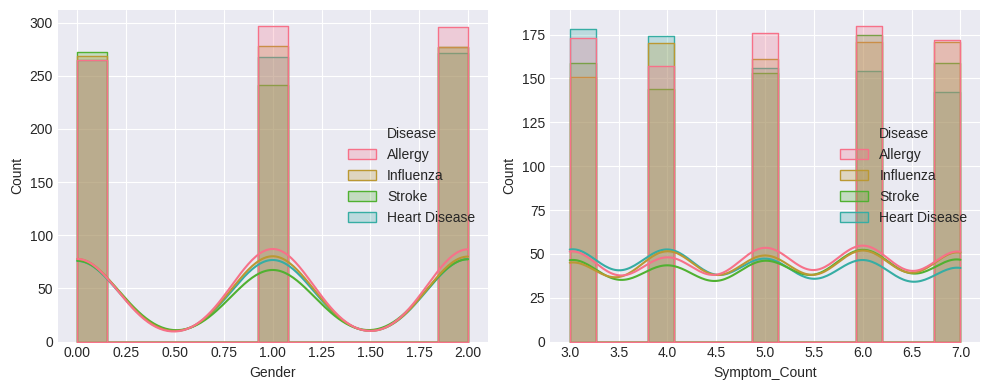

In [61]:
# Диаграммы распределения длины и ширины лепестка по классам
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(
    data=df,
    x="Gender",
    hue="Disease",
    kde=True,
    element="step"
)

plt.subplot(1, 2, 2)
sns.histplot(
    data=df,
    x="Symptom_Count",
    hue="Disease",
    kde=True, # kernel density estimation
    element="step"
)
plt.tight_layout()
plt.show()

In [63]:
df_slice_pd

Age Gender Symptom_Count Symptoms_D1 Symptoms_D2 Symptoms_D3 Symptoms_D4  \
0     29      0             3   -0.012421    -0.35888   -0.415904   -0.251617   
1     78      0             3    0.269444   -0.215358    -0.07469    -0.15591   
2     58      2             4    0.090755    0.364419    0.311787   -0.222661   
3     55      1             3     -0.1926    0.147828   -0.102796   -0.059335   
4     49      0             4   -0.080164    0.369454   -0.073704   -0.506961   
...   ..    ...           ...         ...         ...         ...         ...   
3271  41      0             7    0.185635    0.014265   -0.160145   -0.782746   
3272  62      2             5   -0.210819   -0.271914    0.688083   -0.424792   
3273  79      1             6    0.209795   -0.432782   -0.577294    -0.75309   
3274  39      2             6    0.387436    0.022303   -0.480539    0.209539   
3275  82      2             6    0.290266    0.553211   -0.562028   -0.168551   

     Disease_id  
0             0  
1             2  
2             1  
3             3  
4             3  
...         ...  
3271          2  
3272          3  
3273          1  
3274          0  
3275          0  

[3276 rows x 8 columns]

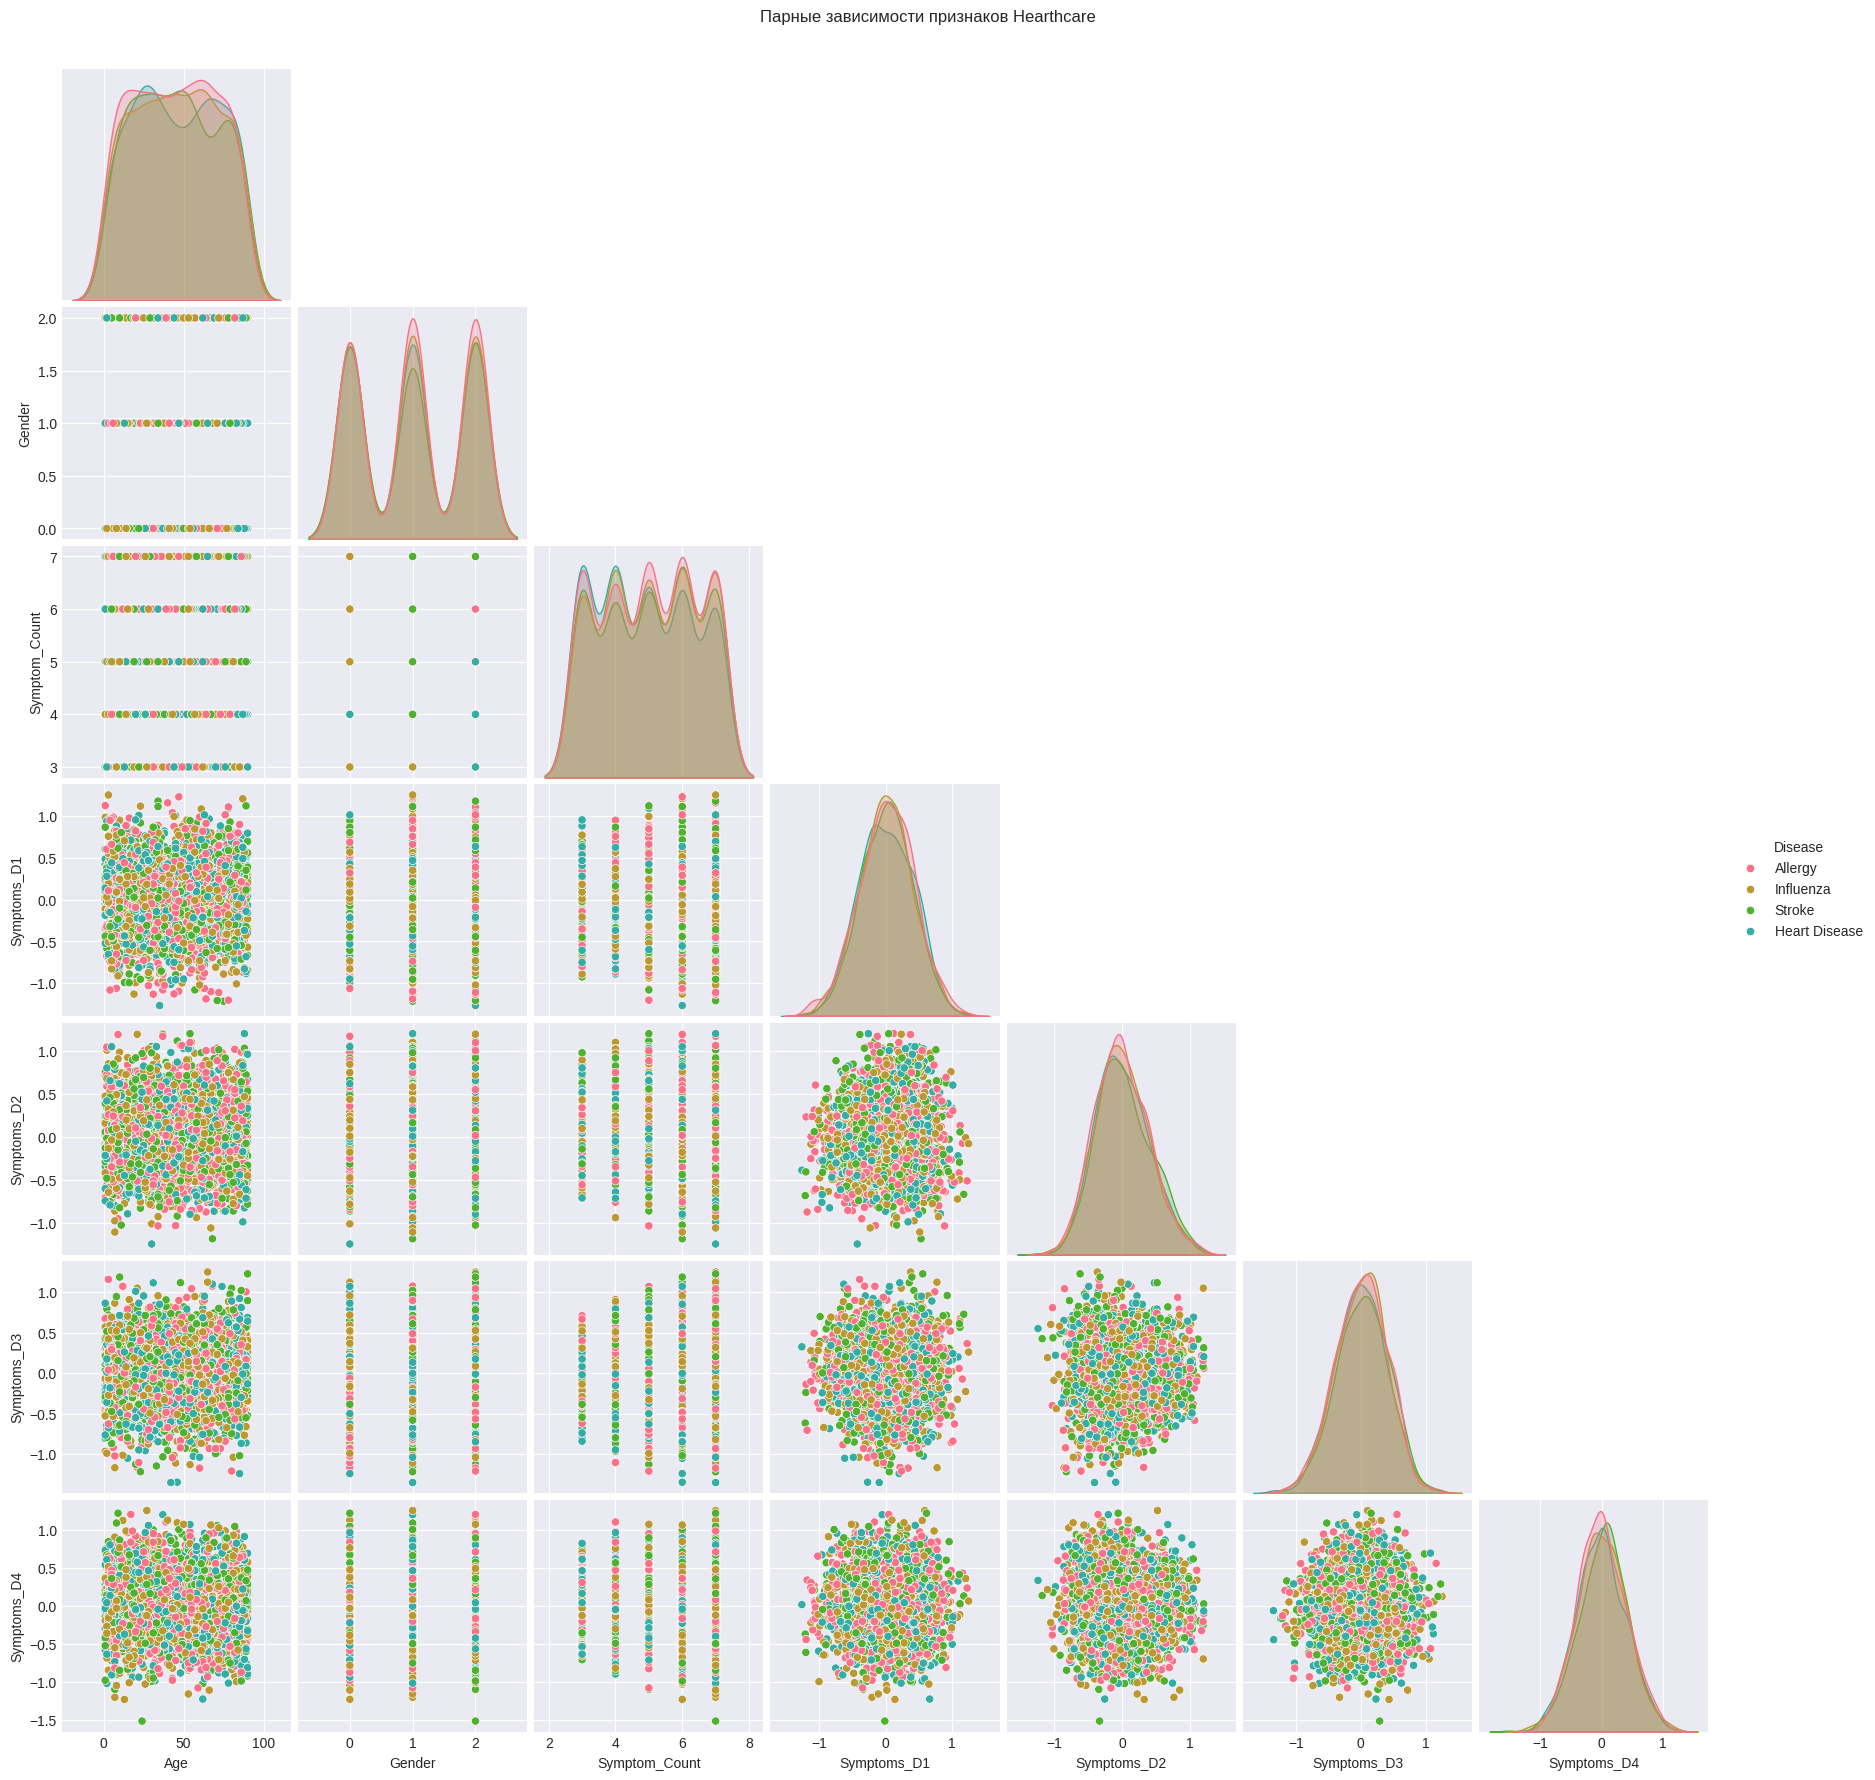

In [69]:
import pandas as pd

df_slice_pd = pd.DataFrame(df,columns=df.columns)
# Парные диаграммы признаков
sns.pairplot(
    df_slice_pd,
    vars=[c for c in df_slice_pd.columns if c!="Symptoms" and 'Disease' not in c],
    hue="Disease",
    corner=True
)
plt.suptitle("Парные зависимости признаков Hearthcare", y=1.02)
plt.show()

In [70]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import RobustScaler

df_numerical = df.drop("Disease")
# scaler = StandardScaler(with_mean=False,with_std=True)
# df_numerical = scaler.fit_transform(df_numerical)

In [71]:
df_numerical

shape: (3_276, 8)
┌─────┬────────┬──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬────────────┐
│ Age ┆ Gender ┆ Symptom_Coun ┆ Symptoms_D1 ┆ Symptoms_D2 ┆ Symptoms_D3 ┆ Symptoms_D4 ┆ Disease_id │
│ --- ┆ ---    ┆ t            ┆ ---         ┆ ---         ┆ ---         ┆ ---         ┆ ---        │
│ i64 ┆ u32    ┆ ---          ┆ f64         ┆ f64         ┆ f64         ┆ f64         ┆ i64        │
│     ┆        ┆ i64          ┆             ┆             ┆             ┆             ┆            │
╞═════╪════════╪══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪════════════╡
│ 29  ┆ 0      ┆ 3            ┆ -0.012421   ┆ -0.35888    ┆ -0.415904   ┆ -0.251617   ┆ 0          │
│ 78  ┆ 0      ┆ 3            ┆ 0.269444    ┆ -0.215358   ┆ -0.07469    ┆ -0.15591    ┆ 2          │
│ 58  ┆ 2      ┆ 4            ┆ 0.090755    ┆ 0.364419    ┆ 0.311787    ┆ -0.222661   ┆ 1          │
│ 55  ┆ 1      ┆ 3            ┆ -0.1926     ┆ 0.147828    ┆ -0.102796   ┆ -0.059335   ┆ 3          │
│ 49  ┆ 0      ┆ 4            ┆ -0.080164   ┆ 0.369454    ┆ -0.073704   ┆ -0.506961   ┆ 3          │
│ …   ┆ …      ┆ …            ┆ …           ┆ …           ┆ …           ┆ …           ┆ …          │
│ 41  ┆ 0      ┆ 7            ┆ 0.185635    ┆ 0.014265    ┆ -0.160145   ┆ -0.782746   ┆ 2          │
│ 62  ┆ 2      ┆ 5            ┆ -0.210819   ┆ -0.271914   ┆ 0.688083    ┆ -0.424792   ┆ 3          │
│ 79  ┆ 1      ┆ 6            ┆ 0.209795    ┆ -0.432782   ┆ -0.577294   ┆ -0.75309    ┆ 1          │
│ 39  ┆ 2      ┆ 6            ┆ 0.387436    ┆ 0.022303    ┆ -0.480539   ┆ 0.209539    ┆ 0          │
│ 82  ┆ 2      ┆ 6            ┆ 0.290266    ┆ 0.553211    ┆ -0.562028   ┆ -0.168551   ┆ 0          │
└─────┴────────┴──────────────┴─────────────┴─────────────┴─────────────┴─────────────┴────────────┘

In [72]:
import umap

reducer = umap.UMAP(random_state=42,n_neighbors=20,min_dist=0.2,metric='cosine')  # UMAP как общий алгоритм понижения размерности.
embedding = reducer.fit_transform(df_numerical)  # проекция в 2D‑пространство. 

umap_df = pd.DataFrame(
    embedding,
    columns=["UMAP1", "UMAP2"]
)

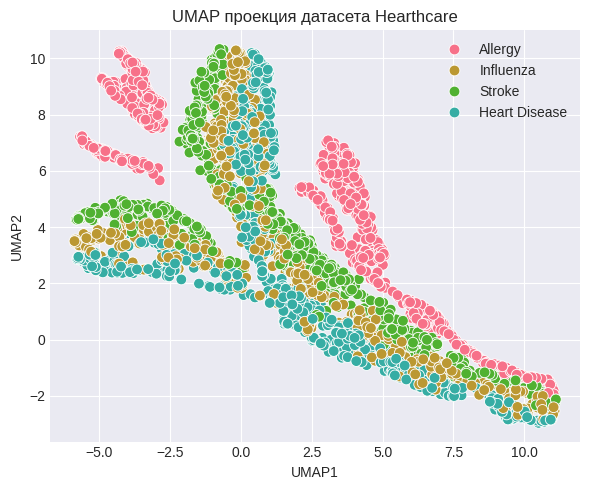

In [73]:
umap_df["Disease"] = disease_col.filter(disease_col.is_in(allowed_diseases))

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=umap_df,
    x="UMAP1",
    y="UMAP2",
    hue="Disease",
    s=60
)
plt.title("UMAP проекция датасета Hearthcare")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
from multidim_visualization import HighDimVisualizer

visualization = HighDimVisualizer(diseases_mapping_inv)
X,Y=df.drop(['Disease']),df['Disease_id']


2. Тепловая карта корреляций


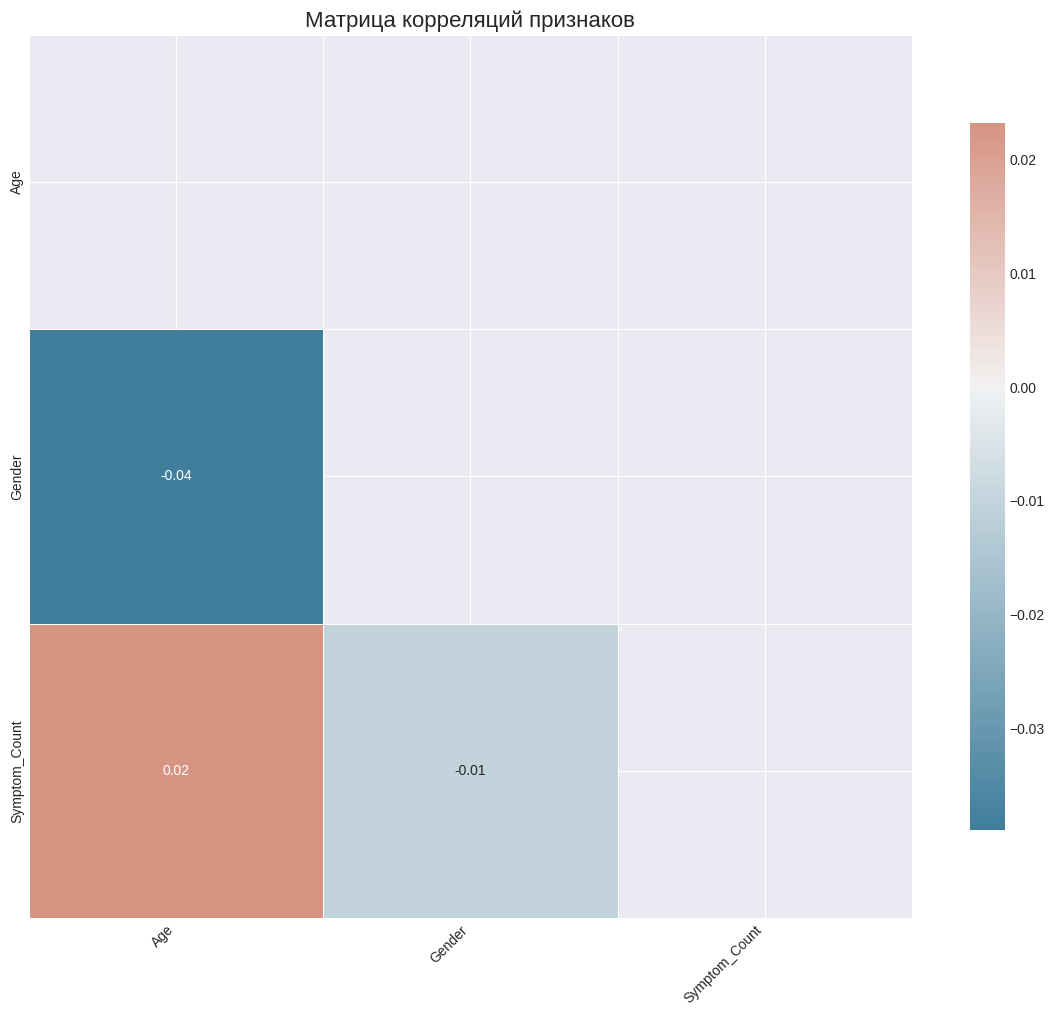

In [18]:
visualization.plot_correlation_heatmap(df['Age',"Gender","Symptom_Count"],['Age',"Gender","Symptom_Count"])

In [74]:
from sklearn.discriminant_analysis import StandardScaler

scaler = StandardScaler()

X_norm = scaler.fit_transform(X)


3. Визуализация PCA (2D и 3D)
Объясненная дисперсия: [0.04719324 0.03704411 0.03658347]
Суммарная объясненная дисперсия: 0.121


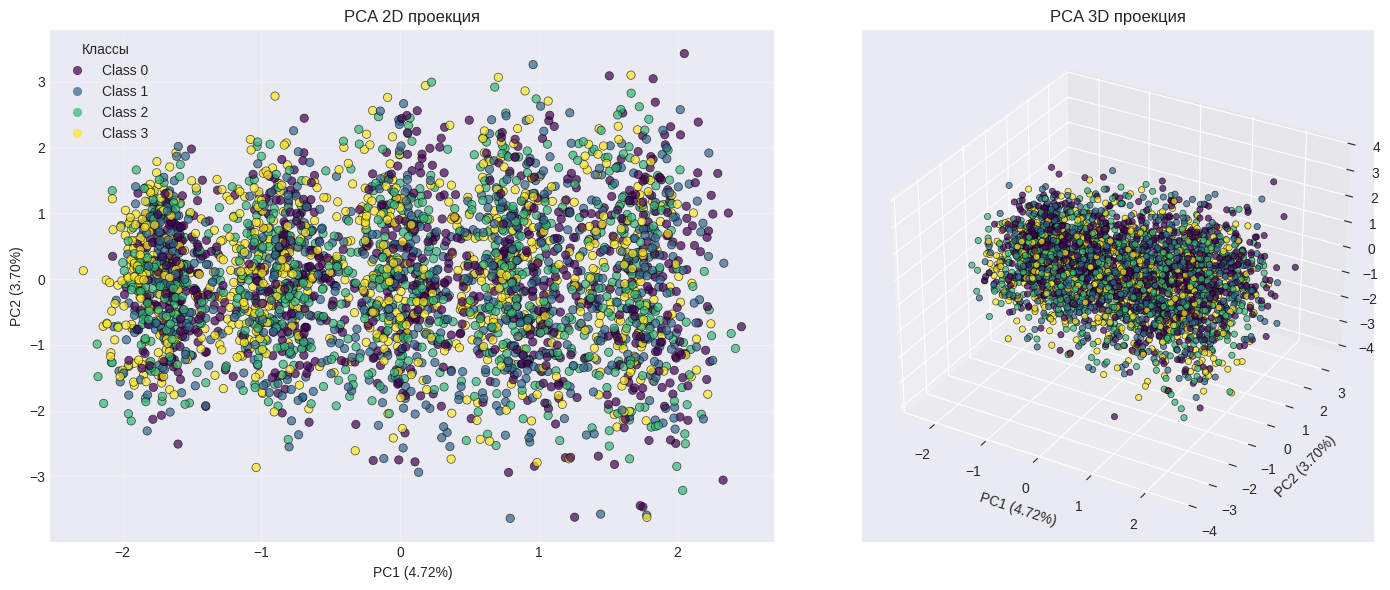

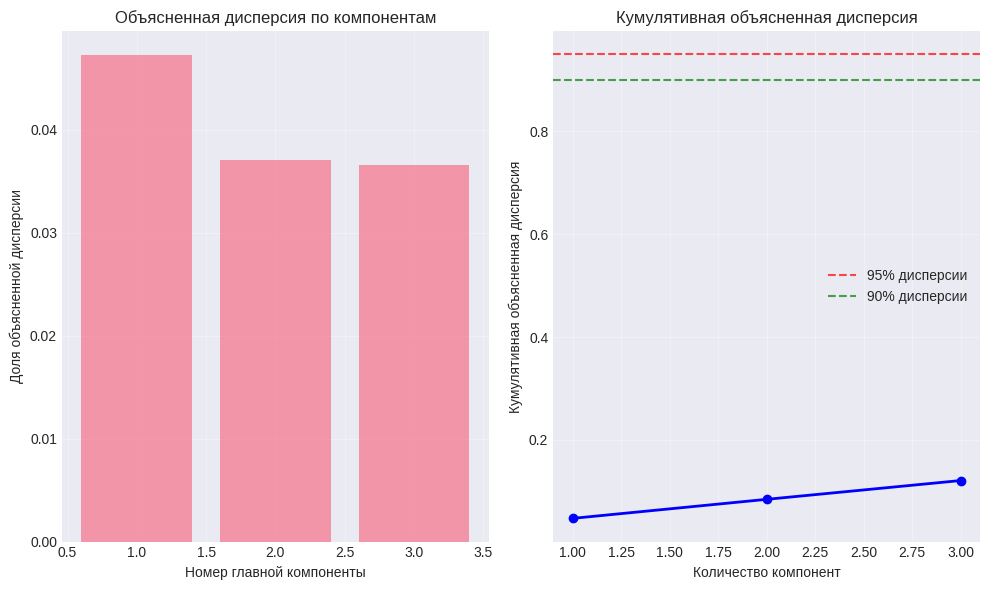

In [75]:
visualization.plot_pca_2d_3d(X_norm,Y)


4. Визуализация t-SNE


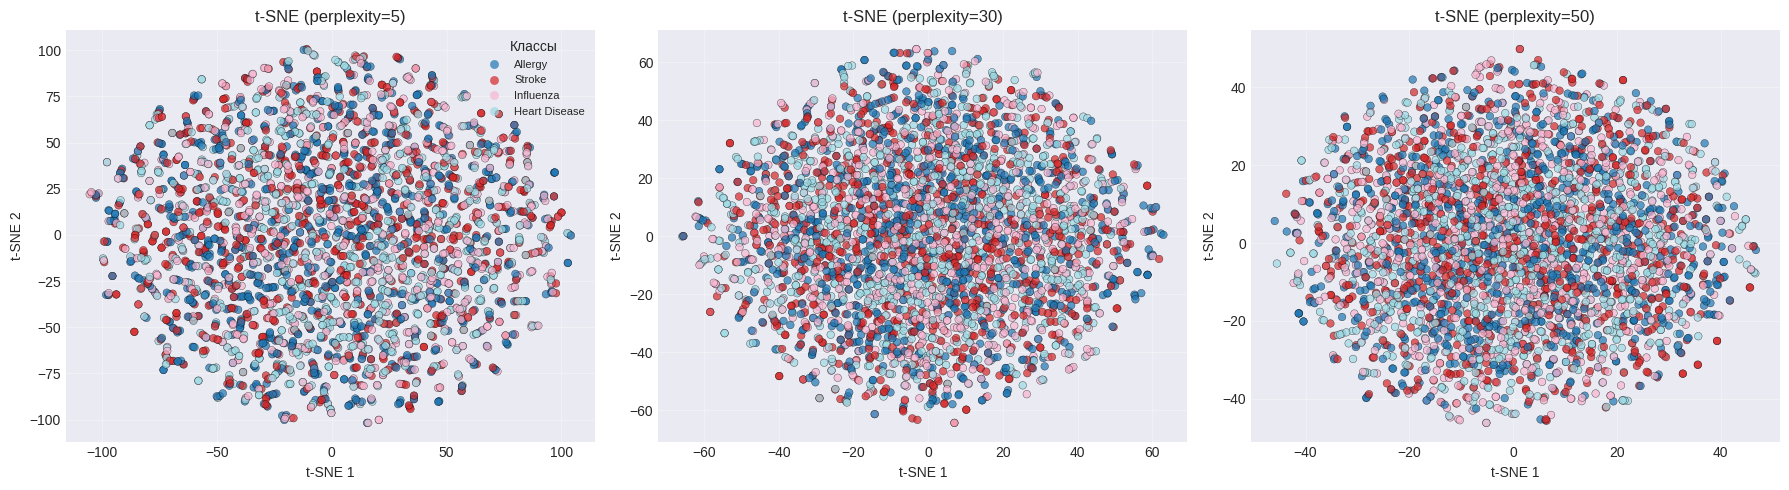

In [21]:
visualization.plot_tsne_visualization(X_norm,Y)


5. Визуализация UMAP


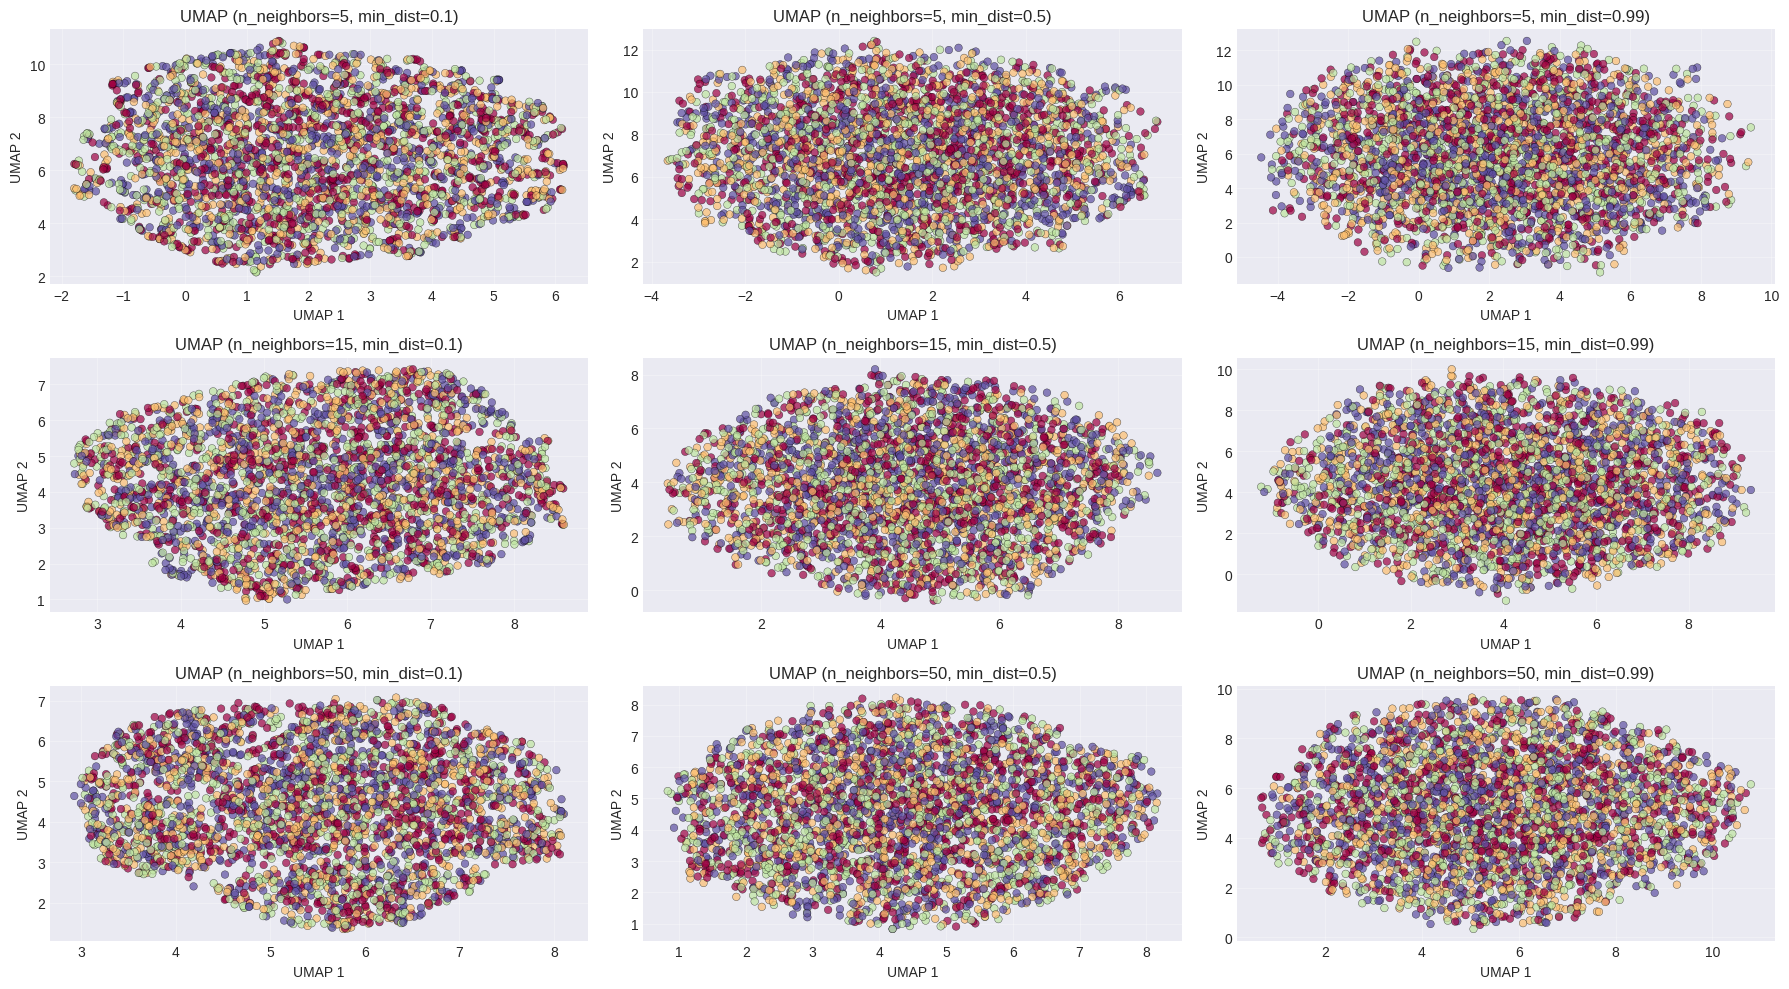

In [22]:
visualization.plot_umap_visualization(X_norm,Y)


6. Параллельные координаты


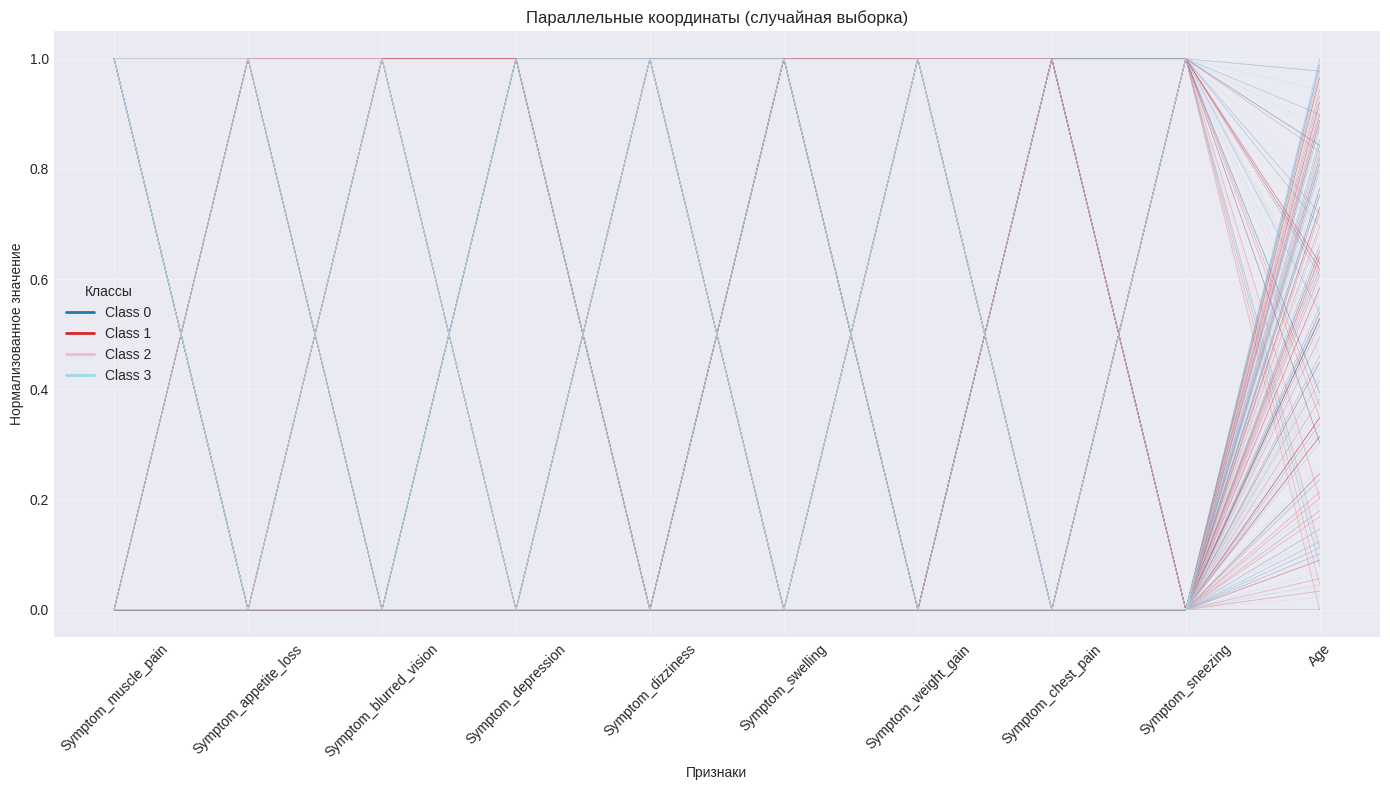

In [23]:
umap_df_num = umap_df[umap_df.columns[:2]].to_numpy()
visualization.plot_parallel_coordinates(X_norm,Y,X.columns)


7. Радар-чарты по классам


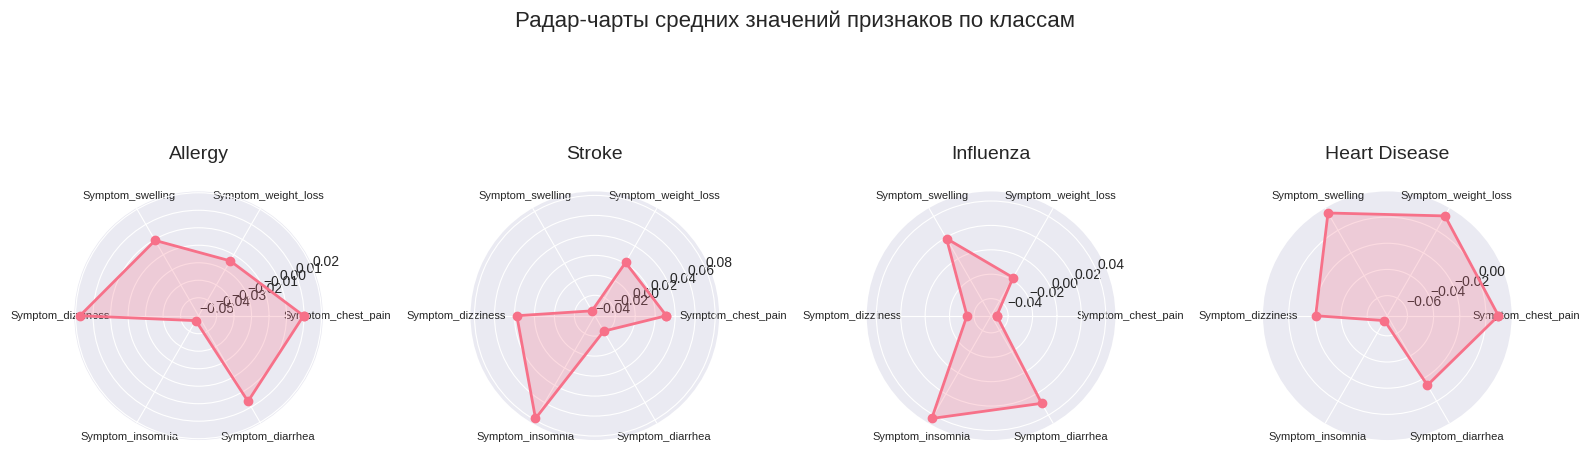

In [24]:
visualization.plot_radar_chart(X_norm,Y,X.columns)

In [25]:
umap3d = umap.UMAP(n_neighbors=30,n_components=3,metric='cosine',min_dist=0.1)
X_3d = umap3d.fit_transform(X)

In [26]:
visualization.plot_interactive_3d(X_3d,Y,["UMAP1","UMAP2","UMAP3"])


8. Интерактивная 3D визуализация (откроется в браузере)
  График сохранен в файл: interactive_3d_plot.html



9. Сравнение методов уменьшения размерности
  Применяем PCA...
  Применяем t-SNE...
  Применяем Isomap...
  Применяем UMAP...


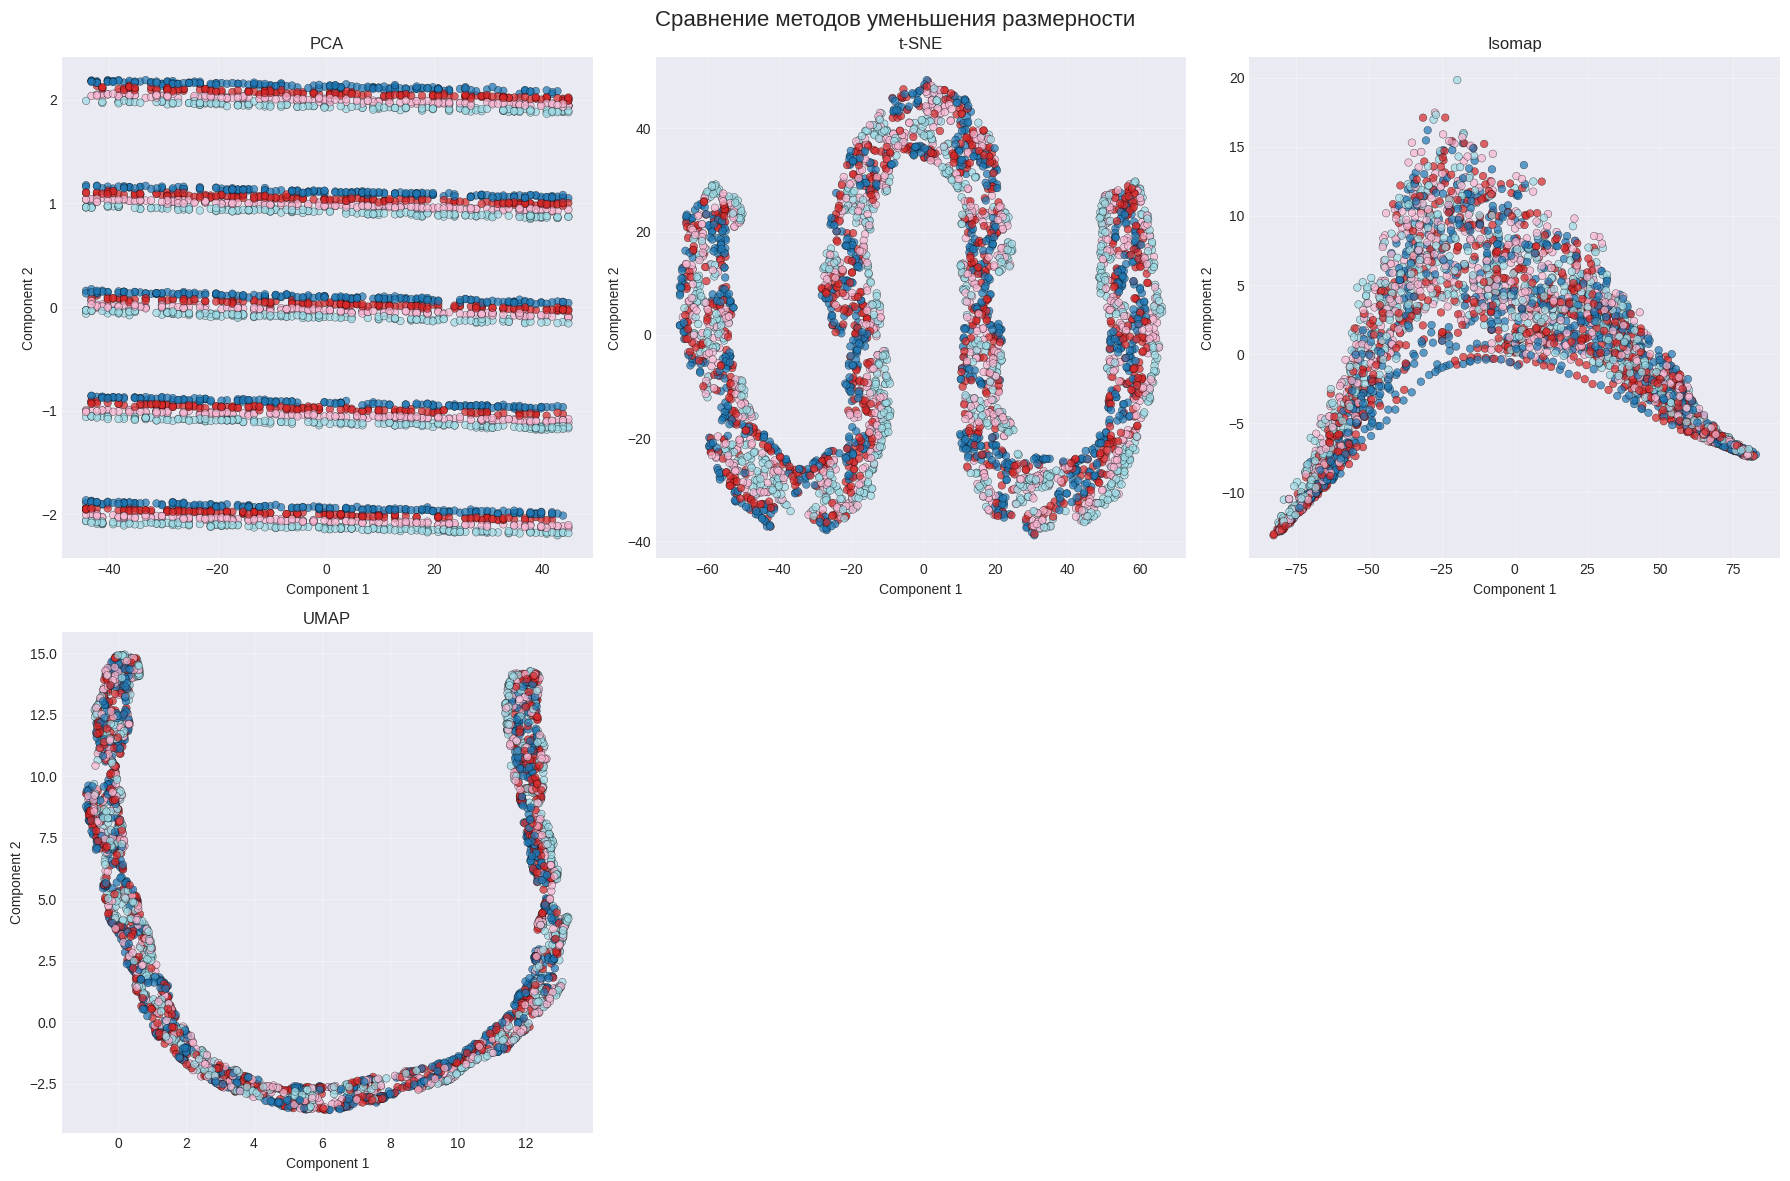

In [27]:
visualization.compare_dim_reduction_methods(X,Y)